In [ ]:
!gdown --id "1VfSk3_wk94k2xXeJ2cYFRJ0N1CO5ecAa"
!gdown --id "1FWDQBS5hwaviRSrrA4G7KSjP3NZd3xWh"
!pip install nltk
!pip install PySastrawi

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VfSk3_wk94k2xXeJ2cYFRJ0N1CO5ecAa
To: /content/Fastext_model_tweet.bin
100% 857M/857M [00:16<00:00, 51.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1FWDQBS5hwaviRSrrA4G7KSjP3NZd3xWh
To: /content/SVMlinear_model.sav
100% 3.18M/3.18M [00:00<00:00, 62.5MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv
import numpy as np
import seaborn as sns
from time import time
from datetime import datetime as dt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
import gensim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from time import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import os

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
file_loc = "https://raw.githubusercontent.com/rizkyyanuark/testpython/main/pemrosesan%20text/project%20pemro/combined_data.csv"
dataset = pd.read_csv(file_loc)
dataset = dataset.iloc[:, :12]
dataset = dataset[dataset.iloc[:, 7] == 'in']
dataset.head(3)

,Mon Nov 06 23:07:13 +0000 2023,1.72167E+18,No indication yet that LRT Jabodebek is putting trainsets repaired trainsets back to work. Maintenance should last 5-7 days per trainset as announced earlier so 1 or 2 trainsets should have been back operating now. But no nothing about that. More problems? #LRTJabodebek,0,0.1,0.2,1,en,1.22449E+18,1.72167E+18.1,johanstravel,https://twitter.com/johanstravel/status/1721665570075193837
0,Mon Nov 06 23:05:07 +0000 2023,1.72167E+18,@lrtjabodebek Selain posting jadwal yg kacau i...,0,0,0,2,in,1.22449E+18,1.72153E+18,johanstravel,https://twitter.com/johanstravel/status/172166...
1,Mon Nov 06 15:39:36 +0000 2023,1.72155E+18,Volume atau jumlah penumpang KRL Commuter Line...,0,0,0,0,in,135795460,1.72155E+18,detikfinance,https://twitter.com/detikfinance/status/172155...
2,Mon Nov 06 16:50:10 +0000 2023,1.72157E+18,@nadsfathinah sebenarnya bukan naik krl sih ka...,0,1,0,0,in,1065117618,1.72154E+18,farizies_,https://twitter.com/farizies_/status/172157068...


In [ ]:
dataset.columns = ["Date", "user", "Tweet",'1','2','3','4','5','6','7','8','9']  # Ganti dengan nama header yang Anda inginkan

# Hapus semua kolom kecuali 'Tweet'
dataset = dataset[['Date','Tweet']]
dataset = dataset.drop_duplicates()
dataset.head(3)

,Date,Tweet
0,Mon Nov 06 23:05:07 +0000 2023,@lrtjabodebek Selain posting jadwal yg kacau i...
1,Mon Nov 06 15:39:36 +0000 2023,Volume atau jumlah penumpang KRL Commuter Line...
2,Mon Nov 06 16:50:10 +0000 2023,@nadsfathinah sebenarnya bukan naik krl sih ka...


In [ ]:
jumlah_tweet = dataset["Tweet"].count()
print(f"Jumlah tweet: {jumlah_tweet}")
jumlah_nan = dataset.isnull().sum().sum()
print(f"Jumlah data NaN: {jumlah_nan}")

Jumlah tweet: 8766
Jumlah data NaN: 0


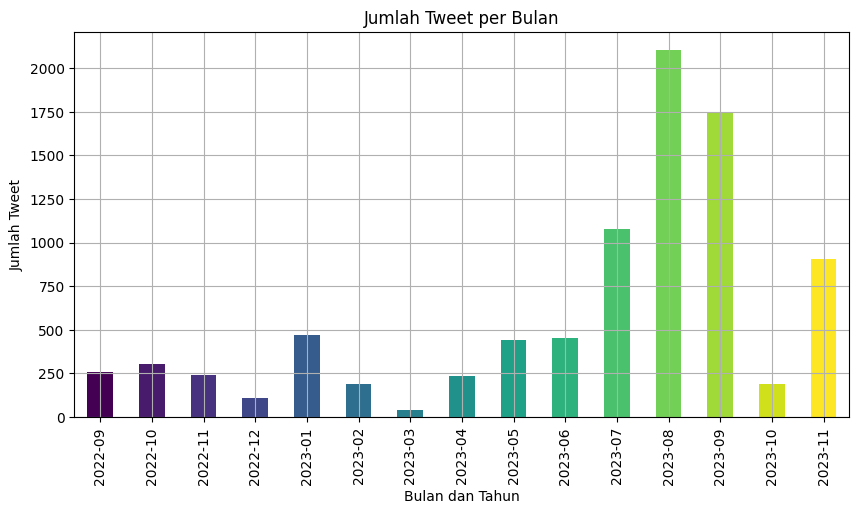

In [ ]:
# Misalkan 'dataset' adalah DataFrame Anda
tweets = dataset.copy()

# Ubah format 'Date' menjadi datetime
tweets['Date'] = pd.to_datetime(tweets['Date'], format='%a %b %d %H:%M:%S +0000 %Y')

# Ekstrak bulan dan tahun dari 'Date' dan buat kolom baru 'YearMonth'
tweets['YearMonth'] = tweets['Date'].dt.to_period('M')

# Hitung jumlah tweet per bulan
monthly_tweets = tweets.groupby('YearMonth').size()

# Buat daftar warna untuk grafik batang
colors = plt.cm.viridis(np.linspace(0, 1, len(monthly_tweets)))

# Plot jumlah tweet per bulan dengan warna
monthly_tweets.plot(kind='bar', figsize=(10, 5), color=colors)

plt.xlabel("Bulan dan Tahun")
plt.ylabel("Jumlah Tweet")
plt.title("Jumlah Tweet per Bulan")
plt.grid(True)
plt.show()
dataset = dataset[['Tweet']]

In [ ]:
alay_dict = pd.read_csv('https://raw.githubusercontent.com/rizkyyanuark/testpython/main/pemrosesan%20text/project%20pemro/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original',
                                      1: 'replacement'})
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

In [ ]:
alay_dict2 = pd.read_csv('https://raw.githubusercontent.com/rizkyyanuark/testpython/main/pemrosesan%20text/project%20pemro/kamus_singkatan_deluxe.csv', sep=';',encoding='latin-1')

alay_dict2.columns = ['original', 'replacement']
alay_dict_map2 = dict(zip(alay_dict2['original'], alay_dict2['replacement']))
alay_dict2.head()

,original,replacement
0,adek,adik
1,adlh,adalah
2,aer,air
3,aiskrim,es krim
4,aj,saja


In [ ]:
def lowercase(text):
    if isinstance(text, str):
        return text.lower()
    else:
        return text
dataset["preprocessed"] = dataset.Tweet.apply(lambda text: lowercase(text))
dataset.head(3)

,Tweet,preprocessed
0,@lrtjabodebek Selain posting jadwal yg kacau i...,@lrtjabodebek selain posting jadwal yg kacau i...
1,Volume atau jumlah penumpang KRL Commuter Line...,volume atau jumlah penumpang krl commuter line...
2,@nadsfathinah sebenarnya bukan naik krl sih ka...,@nadsfathinah sebenarnya bukan naik krl sih ka...


In [ ]:
def remove_link(text):
    text = re.sub('https?://t\.me/[^\s]+', ' ', text) # Menghapus setiap link Telegram
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Menghapus setiap url
    return text
dataset["preprocessed"] = dataset.preprocessed.astype(str).apply(lambda text: remove_link(text))
dataset.head(3)

,Tweet,preprocessed
0,@lrtjabodebek Selain posting jadwal yg kacau i...,@lrtjabodebek selain posting jadwal yg kacau i...
1,Volume atau jumlah penumpang KRL Commuter Line...,volume atau jumlah penumpang krl commuter line...
2,@nadsfathinah sebenarnya bukan naik krl sih ka...,@nadsfathinah sebenarnya bukan naik krl sih ka...


In [ ]:
def transform_emoticons(text):
    text = text.replace("<3", "<love>")
    text = text.replace(":p", "<mengejek>")
    text = text.replace(":P", "<mengejek>")
    text = text.replace(":v", "<melucu>")
    text = text.replace(":V", "<melucu>")
    text = text.replace(":d", "<tertawa>")
    text = text.replace(":D", "<tertawa>")
    text = text.replace(":-D", "<tertawa>")
    text = text.replace(":o", "<terkejut>")
    text = text.replace(":O", "<terkejut>")
    text = text.replace("xD", "<tertawa terbahak bahak>")
    text = text.replace("XD", "<tertawa terbahak bahak>")
    text = text.replace(":*", "<mencium>")
    text = text.replace(":3", "<malu malu kucing>")
    text = text.replace("-__-", "<wajah datar>")
    text = text.replace("-_-", "<wajah datar>")
    text = text.replace(":|", "<wajah datar>")
    text = text.replace(":\\", "<terganggu>")
    text = text.replace(":/", "<terganggu>")
    text = text.replace(":))", "<senyum>")
    text = text.replace(":)", "<senyum>")
    text = text.replace(":-))", "<senyum>")
    text = text.replace(":-)", "<senyum>")
    text = text.replace("^^", "<senyum>")
    text = text.replace("^_^", "<senyum>")
    text = text.replace(";))", "<senyum berkedip>")
    text = text.replace(";)", "<senyum berkedip>")
    text = text.replace(":((", "<sedih>")
    text = text.replace(":(", "<sedih>")
    text = text.replace(":-((", "<sedih>")
    text = text.replace(":-(", "<sedih>")
    text = text.replace(":'((", "<menangis sedih>")
    text = text.replace(":'(", "<menangis sedih>")
    text = text.replace(":'))", "<menangis bahagia>")
    text = text.replace(":')", "<menangis bahagia>")
    text = text.replace(":'", "<menangis sedih>")
    text = text.replace(":’((", "<menangis sedih>")
    text = text.replace(":’(", "<menangis sedih>")
    text = text.replace(":’))", "<menangis bahagia>")
    text = text.replace(":’)", "<menangis bahagia>")
    text = text.replace(":’", "<menangis sedih>")
    text = text.replace(":\"((", "<menangis sedih>")
    text = text.replace(":\"(", "<menangis sedih>")
    text = text.replace(":\"))", "<menangis bahagia>")
    text = text.replace(":\")", "<menangis bahagia>")
    text = text.replace(":\"", "<menangis sedih>")
    text = text.replace(":\"D", "<menangis bahagia>")
    text = text.replace("TT", "<menangis sedih>")
    return text
dataset["preprocessed"] = dataset.preprocessed.apply(lambda text: transform_emoticons(text))
dataset.head(3)

,Tweet,preprocessed
0,@lrtjabodebek Selain posting jadwal yg kacau i...,@lrtjabodebek selain posting jadwal yg kacau i...
1,Volume atau jumlah penumpang KRL Commuter Line...,volume atau jumlah penumpang krl commuter line...
2,@nadsfathinah sebenarnya bukan naik krl sih ka...,@nadsfathinah sebenarnya bukan naik krl sih ka...


In [ ]:
def remove_unnecessary_char(text):
    text = re.sub(r'@[\w]+', '', text) # menghapus username
    text = re.sub('  +', ' ', text) # Menghapus spasi ekstra
    text = re.sub('\n', ' ', text) # Menghapus setiap '\n'
    text = re.sub(r'\brt\b', ' ', text) # Menghapus setiap simbol retweet
    text = re.sub ('[^0-9a-zA-Z]+', ' ', text) # menghapus non aplhanumeric
    text = re.sub(r'\d+', '', text) # menghapus semua angka
    return text
dataset["preprocessed"] = dataset.preprocessed.apply(lambda text: remove_unnecessary_char(text))
dataset.head(3)

,Tweet,preprocessed
0,@lrtjabodebek Selain posting jadwal yg kacau i...,selain posting jadwal yg kacau ini tolong upd...
1,Volume atau jumlah penumpang KRL Commuter Line...,volume atau jumlah penumpang krl commuter line...
2,@nadsfathinah sebenarnya bukan naik krl sih ka...,sebenarnya bukan naik krl sih kalau habis nai...


In [ ]:
def remove_stopword(text):
    stop_words = set(stopwords.words('indonesian'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)
dataset["preprocessed"] = dataset.preprocessed.apply(lambda text: remove_stopword(text))
dataset.head(3)

,Tweet,preprocessed
0,@lrtjabodebek Selain posting jadwal yg kacau i...,posting jadwal yg kacau tolong update ttg trai...
1,Volume atau jumlah penumpang KRL Commuter Line...,volume penumpang krl commuter line meningkat k...
2,@nadsfathinah sebenarnya bukan naik krl sih ka...,krl sih habis kereta cepat whoosh naiknya lrt ...


In [ ]:
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])
dataset["preprocessed"] = dataset.preprocessed.apply(lambda text: normalize_alay(text))
dataset.head(3)

,Tweet,preprocessed
0,@lrtjabodebek Selain posting jadwal yg kacau i...,posting jadwal yang kacau tolong pembaruan ten...
1,Volume atau jumlah penumpang KRL Commuter Line...,volume penumpang kereta listrik commuter line ...
2,@nadsfathinah sebenarnya bukan naik krl sih ka...,kereta listrik sih habis kereta cepat whoosh n...


In [ ]:
def normalize_alay2(text):
    return ' '.join([alay_dict_map2[word] if word in alay_dict_map2 else word for word in text.split(' ')])
dataset["preprocessed"] = dataset.preprocessed.apply(lambda text: normalize_alay2(text))
dataset.head(3)

,Tweet,preprocessed
0,@lrtjabodebek Selain posting jadwal yg kacau i...,posting jadwal yang kacau tolong pembaruan ten...
1,Volume atau jumlah penumpang KRL Commuter Line...,volume penumpang kereta listrik commuter line ...
2,@nadsfathinah sebenarnya bukan naik krl sih ka...,kereta listrik sih habis kereta cepat whoosh n...


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming(text):
    return stemmer.stem(text)
dataset["preprocessed"] = dataset.preprocessed.apply(lambda text: stemming(text))
dataset.head(3)

,Tweet,preprocessed
0,@lrtjabodebek Selain posting jadwal yg kacau i...,posting jadwal yang kacau tolong baru tentang ...
1,Volume atau jumlah penumpang KRL Commuter Line...,volume tumpang kereta listrik commuter line ti...
2,@nadsfathinah sebenarnya bukan naik krl sih ka...,kereta listrik sih habis kereta cepat whoosh n...


In [ ]:
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text
dataset['tokenizing'] = dataset['preprocessed'].apply(tokenizingText)
dataset.head(3)

,Tweet,preprocessed,tokenizing
0,@lrtjabodebek Selain posting jadwal yg kacau i...,posting jadwal yang kacau tolong baru tentang ...,"[posting, jadwal, yang, kacau, tolong, baru, t..."
1,Volume atau jumlah penumpang KRL Commuter Line...,volume tumpang kereta listrik commuter line ti...,"[volume, tumpang, kereta, listrik, commuter, l..."
2,@nadsfathinah sebenarnya bukan naik krl sih ka...,kereta listrik sih habis kereta cepat whoosh n...,"[kereta, listrik, sih, habis, kereta, cepat, w..."


In [ ]:
url_positive = 'https://raw.githubusercontent.com/rizkyyanuark/testpython/main/pemrosesan%20text/project%20pemro/kamus_positif.xlsx'
lexicon_positive = pd.read_excel(url_positive)
lexicon_positive_dict = {}
for index, row in lexicon_positive.iterrows():
    if row[0] not in lexicon_positive_dict:
        lexicon_positive_dict[row[0]] = row[1]
url_negative = 'https://raw.githubusercontent.com/rizkyyanuark/testpython/main/pemrosesan%20text/project%20pemro/kamus_negatif.xlsx'
lexicon_negative = pd.read_excel(url_negative)
lexicon_negative_dict = {}
for index, row in lexicon_negative.iterrows():
    if row[0] not in lexicon_negative_dict:
        lexicon_negative_dict[row[0]] = row[1]

def sentiment_analysis_lexicon_indonesia(ulasan):
    score = 0
    for word in ulasan:
        if (word in lexicon_positive_dict):
            score = score + lexicon_positive_dict[word]
    for word in ulasan:
        if (word in lexicon_negative_dict):
            score = score + lexicon_negative_dict[word]
    sentimen=''
    if (score > 0):
        sentimen = 'positive'
    elif (score < 0):
        sentimen = 'negative'
    else:
        sentimen = 'netral'
    return score, sentimen

results = dataset['tokenizing'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
dataset['polarity_score'] = results[0]
dataset['polarity'] = results[1]
print(dataset['polarity'].value_counts())
dataset.head(3)

netral      4336
positive    3293
negative    1137
Name: polarity, dtype: int64


,Tweet,preprocessed,tokenizing,polarity_score,polarity
0,@lrtjabodebek Selain posting jadwal yg kacau i...,posting jadwal yang kacau tolong baru tentang ...,"[posting, jadwal, yang, kacau, tolong, baru, t...",0,netral
1,Volume atau jumlah penumpang KRL Commuter Line...,volume tumpang kereta listrik commuter line ti...,"[volume, tumpang, kereta, listrik, commuter, l...",0,netral
2,@nadsfathinah sebenarnya bukan naik krl sih ka...,kereta listrik sih habis kereta cepat whoosh n...,"[kereta, listrik, sih, habis, kereta, cepat, w...",2,positive


In [ ]:
import pandas as pd
# Loads lexicon positive and negative data
url_positive = 'https://raw.githubusercontent.com/rizkyyanuark/testpython/main/pemrosesan%20text/project%20pemro/lexicon_positive.csv'
lexicon_positive = pd.read_csv(url_positive, index_col=0, squeeze=True).to_dict()
url_negative = 'https://raw.githubusercontent.com/rizkyyanuark/testpython/main/pemrosesan%20text/project%20pemro/lexicon_negative.csv'
lexicon_negative = pd.read_csv(url_negative, index_col=0, squeeze=True).to_dict()
# Function to determine sentiment polarity of tweets
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        score += lexicon_positive.get(word, 0)
        score += lexicon_negative.get(word, 0)
    if score > 0:
        return score, 'positive'
    elif score < 0:
        return score, 'negative'
    else:
        return score, 'neutral'
results = dataset['tokenizing'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
dataset['polarity_score'] = results[0]
dataset['polarity'] = results[1]
print(dataset['polarity'].value_counts())
dataset.head(3)

In [ ]:
import seaborn as sns

# Ambil sampel satu kalimat
sample = dataset['tokenizing'].sample(1)
# Hitung skor sentimen untuk setiap token dalam sampel
sample_sentence = sample.iloc[0]
sentiments = [sentiment_analysis_lexicon_indonesia([word])[0] for word in sample_sentence]

# Buat DataFrame untuk visualisasi
vis_data = {
    "Sentence": ["SENTENCE"] + sample_sentence,
    "Sentiment": [sentiment_analysis_lexicon_indonesia(sample_sentence)[0]] + sentiments
}
# Fungsi untuk memvisualisasikan sentimen
def visualise_sentiments(data):
    sns.set(rc={'figure.figsize':(30,1)})
    sns.heatmap(pd.DataFrame(data).set_index("Sentence").T, center=0, annot=True, cmap="PiYG")
# Visualisasikan sentimen
visualise_sentiments(vis_data)
sample

TypeError: ignored

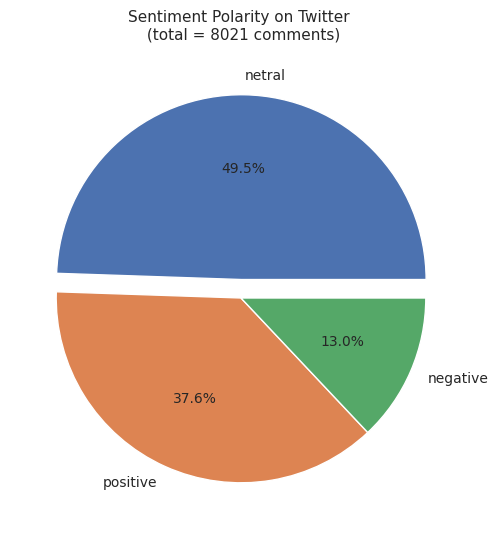

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in dataset['polarity'].value_counts()]
labels = list(dataset['polarity'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 10})
ax.set_title('Sentiment Polarity on Twitter \n (total = 8021 comments)', fontsize = 11, pad = 20)
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', 3000)
positive_comments = dataset[dataset['polarity'] == 'positive']
positive_comments = positive_comments[['preprocessed', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_comments.index += 1
positive_comments[122:126]

,preprocessed,polarity_score,polarity
123,pribadi nilai tansportasi tarik perhati masyarakat murah harga laku khusus jalan khusus ex tj jalur khusus jalan macet jalur tj lancar habis razia cepat sesuai jadwal tunggu,6,positive
124,ujicoba light rail transit jabodebek kes adem ayem tidak berita benar coba tidak itu kereta,6,positive
125,jokowi telah ri mnjd negara maju lihat jakarta walau diberantakin tidak benar asing turun yen beliau bangkit lihat jakarta kota impi dunia jalur mrt jalur light rail transit jalur kereta cepat tol jakarta telah hias ibu kota dengan indah dan modern belum yang karya untuk selamat ulang tahun jokowi,6,positive
126,top news kemenhub henti uji coba batas light rail transit jabodebek senin henti uji coba baik sempurna sistem software baca lengkap lrtjabodebek kemenhub,6,positive


In [ ]:
pd.set_option('display.max_colwidth', 3000)
positive_comments = dataset[dataset['polarity'] == 'negative']
positive_comments = positive_comments[['preprocessed', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_comments.index += 1
positive_comments[200:205]

,preprocessed,polarity_score,polarity
201,hi teman raina raina kasih info nih fasilitas sembarang ya bahaya lrtjabodebek smarttravellivebetter,-1,negative
202,hi teman raina kali bahas fasilitas stasiun fasilitas tumpang penasaran yuk simak postingannya lrtjabodebek smarttravellivebetter,-1,negative
203,hi teman raina penasaran teknologi sinyal simak postingan ya lrtjabodebek smarttravellivebetter,-1,negative
204,tanyarl kasihan sekali admin light rail transit jakarta kena salah sasar light rail transit jabodebek terus,-1,negative
205,alas nya yang batal kalau tarif turunin uji coba layak tarif sudah jangam operasional konsumen yang rugi,-1,negative


In [ ]:
# Visualize word cloud
list_words=''
for comment in dataset['tokenizing']:
    for word in comment:
        list_words += ' '+(word)
wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Comments Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [ ]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]
        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)

    return positive_words, negative_words
# Visualize positive and negative word cloud
sentiment_words = dataset['tokenizing'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on comments Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on comments Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

In [ ]:
from sklearn import model_selection
# Membagi set data latih dan data uji dengan rasio 70:30
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dataset['tokenizing'],
                                                                    dataset['polarity'],test_size=0.3, random_state=42)

In [ ]:
print(Train_X.size, Train_X.size/(Test_X.size+Train_X.size),'%','\n',
      Test_X.size, Test_X.size/(Test_X.size+Train_X.size),'%')

6136 0.6999771845767739 % 
 2630 0.3000228154232261 %


In [ ]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [ ]:
# Gabungkan token menjadi string
dataset['tokenizing'] = dataset['tokenizing'].apply(' '.join)
# Lalu, Anda bisa menggunakan CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(dataset['tokenizing'])

In [ ]:
# Gabungkan token menjadi string
Train_X = Train_X.apply(' '.join)
Test_X = Test_X.apply(' '.join)
# Lalu, Anda bisa menggunakan CountVectorizer
Train_X_BoW = vectorizer.transform(Train_X)
Test_X_BoW = vectorizer.transform(Test_X)

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=None).fit(dataset['tokenizing'])
Tfidf_vect = TfidfVectorizer(max_features=5000).fit(dataset['tokenizing'])
Tfidf_vect = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True,use_idf=True).fit(dataset['tokenizing'])

In [ ]:
# Transform Train_X dan Test_X ke vektor TF-IDF
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto/scale
svc=SVC()

# declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 100, 1000], 'kernel':['linear']},
               {'C':[1, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]}
              ]

In [ ]:
grid_search = GridSearchCV(estimator = svc,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

#Train data BoW
grid_search.fit(Train_X_BoW, Train_Y)

In [ ]:
grid_search_Tfidf = GridSearchCV(estimator = svc,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
#Train data TF-IDF
grid_search_Tfidf.fit(Train_X_Tfidf, Train_Y)

In [ ]:
grid_search_fasttext = GridSearchCV(estimator = svc,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

#Train data BoW
grid_search_fasttext.fit(vectors_train, Train_Y)

In [ ]:
### BoW ###
# examine the best model
# best score achieved during the GridSearchCV
print('\n\n---BoW---\n')
print('GridSearch CV best score : {:.4f}\n'.format(grid_search.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :', (grid_search.best_params_))
# print estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search :', (grid_search.best_estimator_))

### TF-IDF ###
# examine the best model
# best score achieved during the GridSearchCV
print('\n\n---TF-IDF---\n')
print('GridSearch CV best score : {:.4f}\n'.format(grid_search_Tfidf.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :', (grid_search_Tfidf.best_params_))
# print estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search :', (grid_search_Tfidf.best_estimator_))

In [ ]:
### FastText ###
# examine the best model
# best score achieved during the GridSearchCV
print('\n\n---TF-IDF---\n')
print('GridSearch CV best score : {:.4f}\n'.format(grid_search_fasttext.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :', (grid_search_fasttext.best_params_))
# print estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search :', (grid_search_fasttext.best_estimator_))

In [ ]:
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(Test_X_BoW, Test_Y)))
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search_Tfidf.score(Test_X_Tfidf, Test_Y)))

In [ ]:
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search_fasttext.score(vectors_test, Test_Y)))

In [ ]:
from sklearn import model_selection, svm
# Menggunakan SVM dengan kernel hasil Grid Search CV sebagai classifier
linear1000 = svm.SVC(kernel='linear', C=1000.0, random_state=42)#karnel linier dengan C=1000.0
rbf100=SVC(C=100.0, gamma=0.1, random_state=42) #karnel RBF dengan C=100.0
poly1000 = SVC(C=1000, degree=3, gamma=0.04, kernel='poly')#karnel poly dengan c=1000

In [ ]:
# SVM dengan Karnel Linier C=1000.0
## fitting data latih pada classifier
linear1000.fit(Train_X_BoW,Train_Y)
## memprediksi label pada set data uji
predictions_SVM_BoW_Linier1000 = linear1000.predict(Test_X_BoW)
## Menggunakan fungsi accuracy_score untuk mendapat nilai akurasi
accuracy_Bow_linear1000 = accuracy_score(Test_Y, predictions_SVM_BoW_Linier1000)*100
print('Model accuracy score with linear kernel and C=1000.0  -> ', accuracy_Bow_linear1000)

Model accuracy score with linear kernel and C=1000.0  ->  89.77186311787072


In [ ]:
#### SVM dengan Karnel RBF dan C=100.0 Gamma =0.1####
# fitting data latih pada classifier
rbf100.fit(Train_X_Tfidf,Train_Y)

# memprediksi label pada set data uji
predictions_SVM_Tfidf_RBF100 = rbf100.predict(Test_X_Tfidf)

# Menggunakan fungsi accuracy_score untuk mendapat nilai akurasi
accuracy_Tfidf_rbf100 = accuracy_score(Test_Y, predictions_SVM_Tfidf_RBF100)*100
print('Model accuracy score with rbf kernel and C=100.0 -> ', accuracy_Tfidf_rbf100)

Model accuracy score with rbf kernel and C=100.0 ->  86.27376425855513


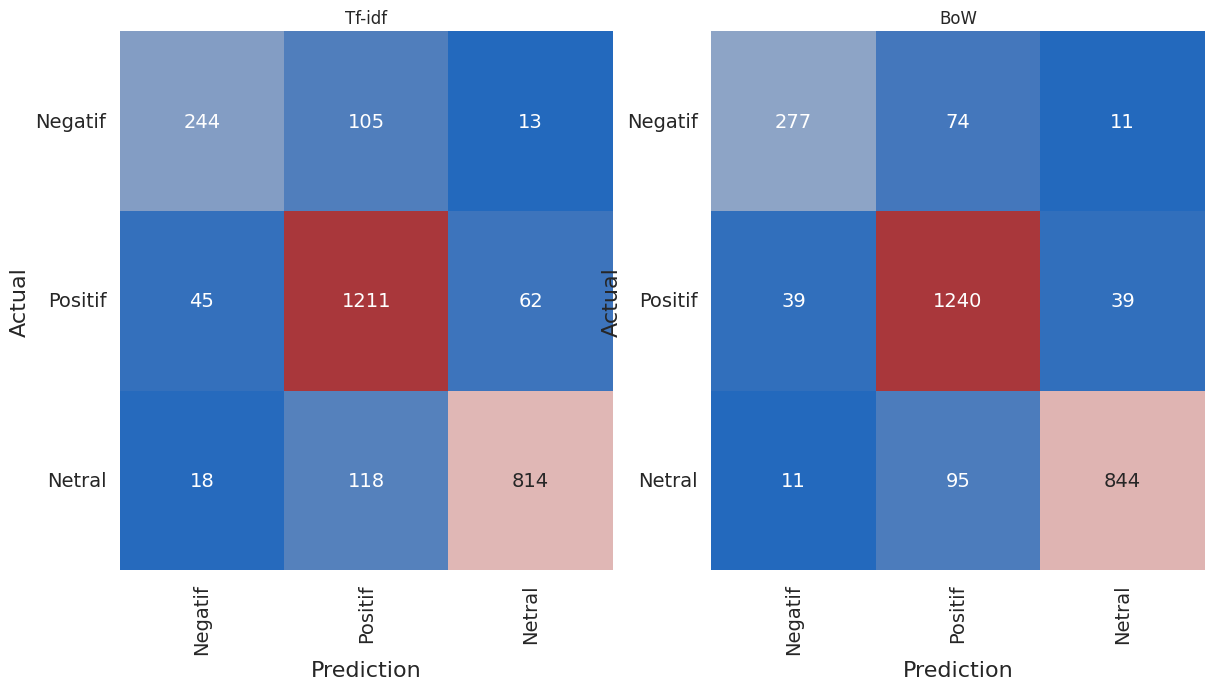

In [ ]:
figure, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot untuk Tf-idf
sns.heatmap(confusion_matrix(Test_Y, predictions_SVM_Tfidf_RBF100), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False, ax=ax[0])
ax[0].set_xticklabels(["Negatif", "Positif", "Netral"], fontsize="14", rotation=90)
ax[0].set_yticklabels(["Negatif", "Positif", "Netral"], fontsize="14", rotation=0)
ax[0].set_xlabel('Prediction', fontsize=16)
ax[0].set_ylabel('Actual', fontsize=16)
ax[0].set_title('Tf-idf')

# Plot untuk BoW
# Ganti 'predictions_SVM_BoW_RBF100' dengan prediksi SVM Anda untuk BoW
sns.heatmap(confusion_matrix(Test_Y, predictions_SVM_BoW_Linier1000), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False, ax=ax[1])
ax[1].set_xticklabels(["Negatif", "Positif", "Netral"], fontsize="14", rotation=90)
ax[1].set_yticklabels(["Negatif", "Positif", "Netral"], fontsize="14", rotation=0)
ax[1].set_xlabel('Prediction', fontsize=16)
ax[1].set_ylabel('Actual', fontsize=16)
ax[1].set_title('BoW')

plt.show()


In [ ]:
#dataset.to_csv("/content/drive/MyDrive/pemrosesan text/clean dataset.csv", index=False)